# CME Gap Analysis

This notebook provides an interactive analysis of CME gaps in Bitcoin price data.


In [1]:
import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path().absolute().parent / 'src'))

from cme_gap_analyzer.data_downloader import download_btc_candles
from cme_gap_analyzer.gap_detector import detect_cme_gaps, find_gap_closures
from cme_gap_analyzer.statistics import calculate_gap_statistics, print_statistics
from cme_gap_analyzer.visualizations import (
    plot_gap_statistics,
    plot_price_action_with_gaps,
    plot_closure_analysis
)

import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline


## Download Bitcoin Price Data


In [2]:
# Download data (adjust dates as needed)
df = download_btc_candles(
    start_date='2022-01-01',
    end_date=None,  # Until now
    interval='1h',
    exchange='binance'
)

print(f"Downloaded {len(df)} candles")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
df.head()


Start: 2022-01-01 00:00:00, End: 2025-11-26 14:48:01.283000
Downloaded 34214 candles
Downloaded 34214 candles
Date range: 2022-01-01 00:00:00 to 2025-11-26 14:00:00


,timestamp,open,high,low,close,volume
0,2022-01-01 00:00:00,46216.93,46731.39,46208.37,46656.13,1503.33095
1,2022-01-01 01:00:00,46656.14,46949.99,46574.06,46778.14,943.81539
2,2022-01-01 02:00:00,46778.14,46928.94,46721.96,46811.77,485.16860
3,2022-01-01 03:00:00,46811.77,46916.63,46760.12,46813.20,562.88971
4,2022-01-01 04:00:00,46813.21,46887.33,46591.23,46711.05,861.88389


## Detect CME Gaps


In [3]:
# Detect gaps
gaps_df = detect_cme_gaps(df, local_tz='America/Chicago')

print(f"Detected {len(gaps_df)} CME gaps")
gaps_df.head()


Detected 203 CME gaps


,gap_start,gap_end,close_price,open_price,gap_size,gap_size_pct,gap_direction,friday_date,sunday_date
0,2022-01-07 22:00:00+00:00,2022-01-09 23:00:00+00:00,41541.82,42205.36,663.54,1.597282,up,2022-01-07,2022-01-09
1,2022-01-14 22:00:00+00:00,2022-01-16 23:00:00+00:00,43250.56,43190.00,-60.56,-0.140021,down,2022-01-14,2022-01-16
2,2022-01-21 22:00:00+00:00,2022-01-23 23:00:00+00:00,36117.60,35508.47,-609.13,-1.686518,down,2022-01-21,2022-01-23
3,2022-01-28 22:00:00+00:00,2022-01-30 23:00:00+00:00,37655.01,37785.78,130.77,0.347284,up,2022-01-28,2022-01-30
4,2022-02-04 22:00:00+00:00,2022-02-06 23:00:00+00:00,40641.74,41590.74,949.00,2.335038,up,2022-02-04,2022-02-06


## Find Gap Closures


In [4]:
# Find closures
gaps_df = find_gap_closures(df, gaps_df)

closed_count = gaps_df['is_closed'].sum()
print(f"Closed gaps: {closed_count}/{len(gaps_df)}")
print(f"Closure rate: {closed_count/len(gaps_df)*100:.2f}%")

# Show closed gaps
closed_gaps = gaps_df[gaps_df['is_closed']]
if not closed_gaps.empty:
    print("\nSample of closed gaps:")
    closed_gaps[['gap_start', 'gap_size', 'days_to_close']].head(10)


Closed gaps: 196/203
Closure rate: 96.55%

Sample of closed gaps:


## Calculate Statistics


In [5]:
# Calculate and print statistics
stats = calculate_gap_statistics(gaps_df)
print_statistics(stats)



CME GAP STATISTICS

Total Gaps Detected: 203
  - Closed: 196
  - Open: 7
  - Closure Rate: 96.55%

Gap Size Statistics:
  - Average: $768.16 (1.35%)
  - Median: $383.99
  - Std Dev: $1,168.42

Largest Gap:
  - Size: $10,097.42 (12.00%)
  - Direction: up
  - Date: 2025-02-28 22:00:00+00:00
  - Closed: True

Smallest Gap:
  - Size: $4.92 (0.03%)
  - Direction: up
  - Date: 2023-01-06 22:00:00+00:00
  - Closed: False

Closure Time Statistics (for closed gaps):
  - Average: 236.0 hours (9.84 days)
  - Median: 13.0 hours (0.54 days)
  - Range: 1.0 - 13012.0 hours

Direction Statistics:
  - Upward Gaps: 115 (Closure Rate: 93.91%)
  - Downward Gaps: 88 (Closure Rate: 100.00%)
  - Avg Up Gap Size: $759.61
  - Avg Down Gap Size: $-779.33

Gaps Closed Within One Week:
  - Count: 171 (84.24% of all gaps)
  - Percentage of closed gaps: 87.24%



## Visualizations


/home/onat/qt__cma_gap/src/cme_gap_analyzer/visualizations.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = gaps_df.groupby(gap_bins).agg({


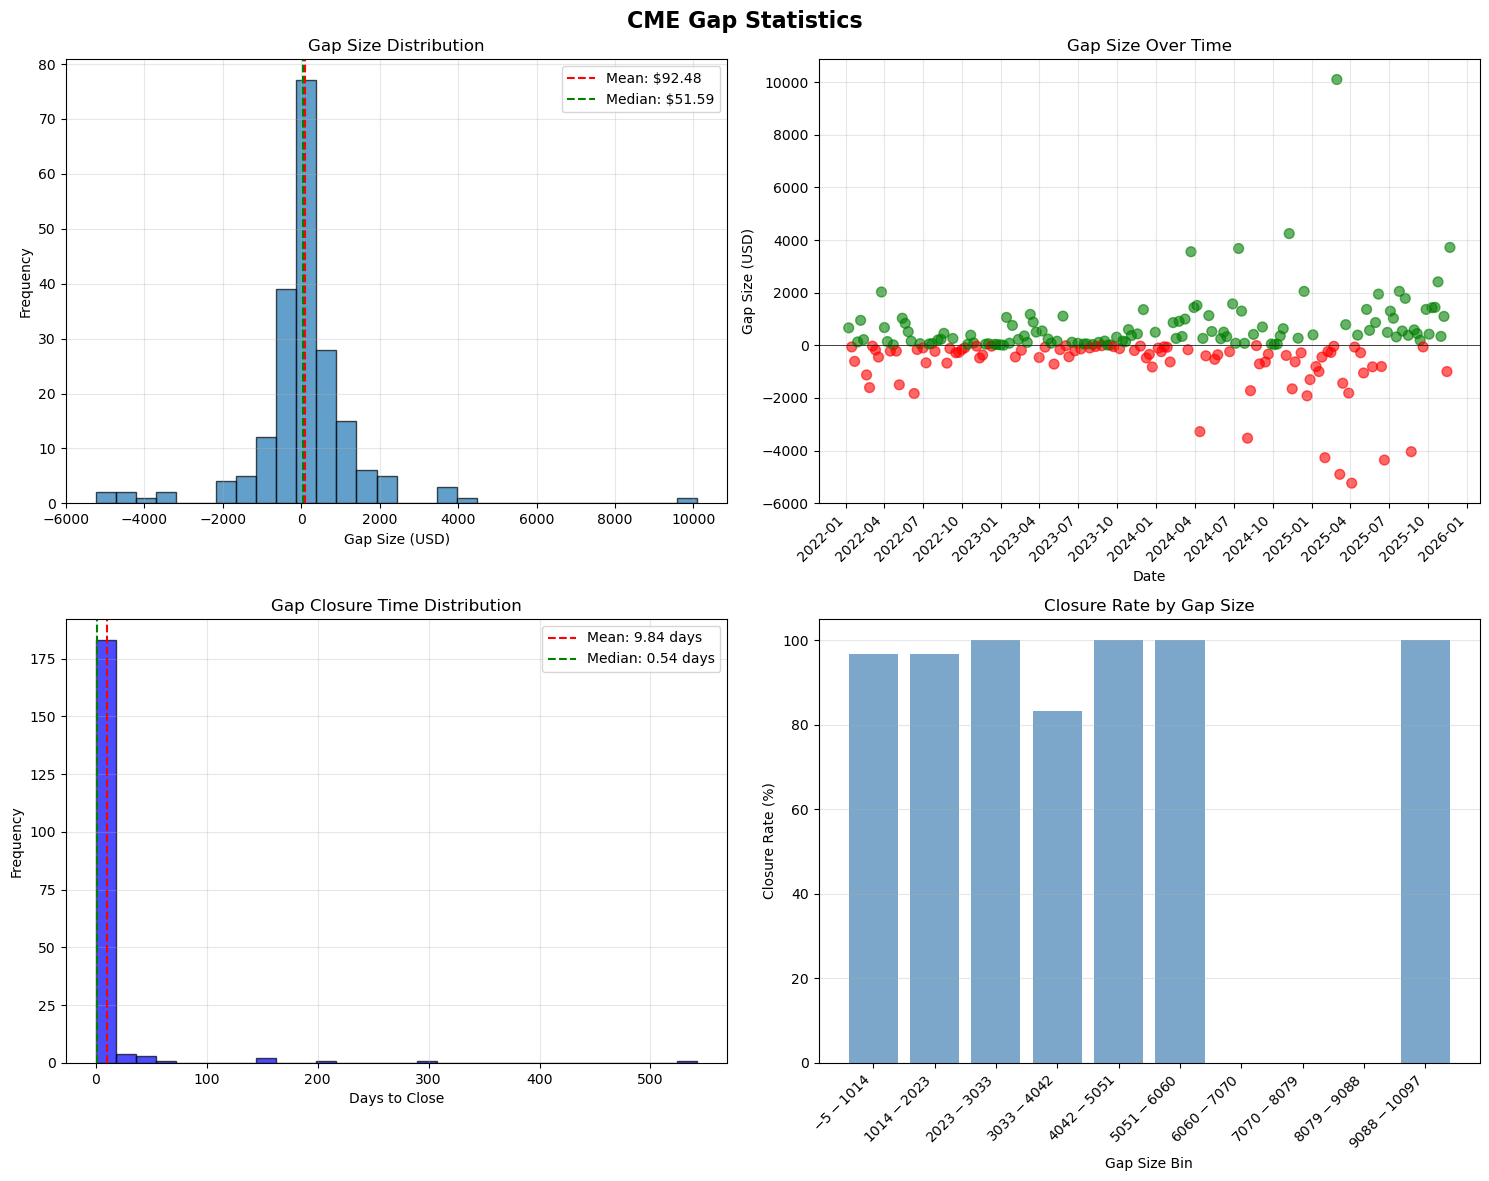

In [10]:
# Plot gap statistics
plot_gap_statistics(gaps_df)

/home/onat/qt__cma_gap/src/cme_gap_analyzer/visualizations.py:167: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle(


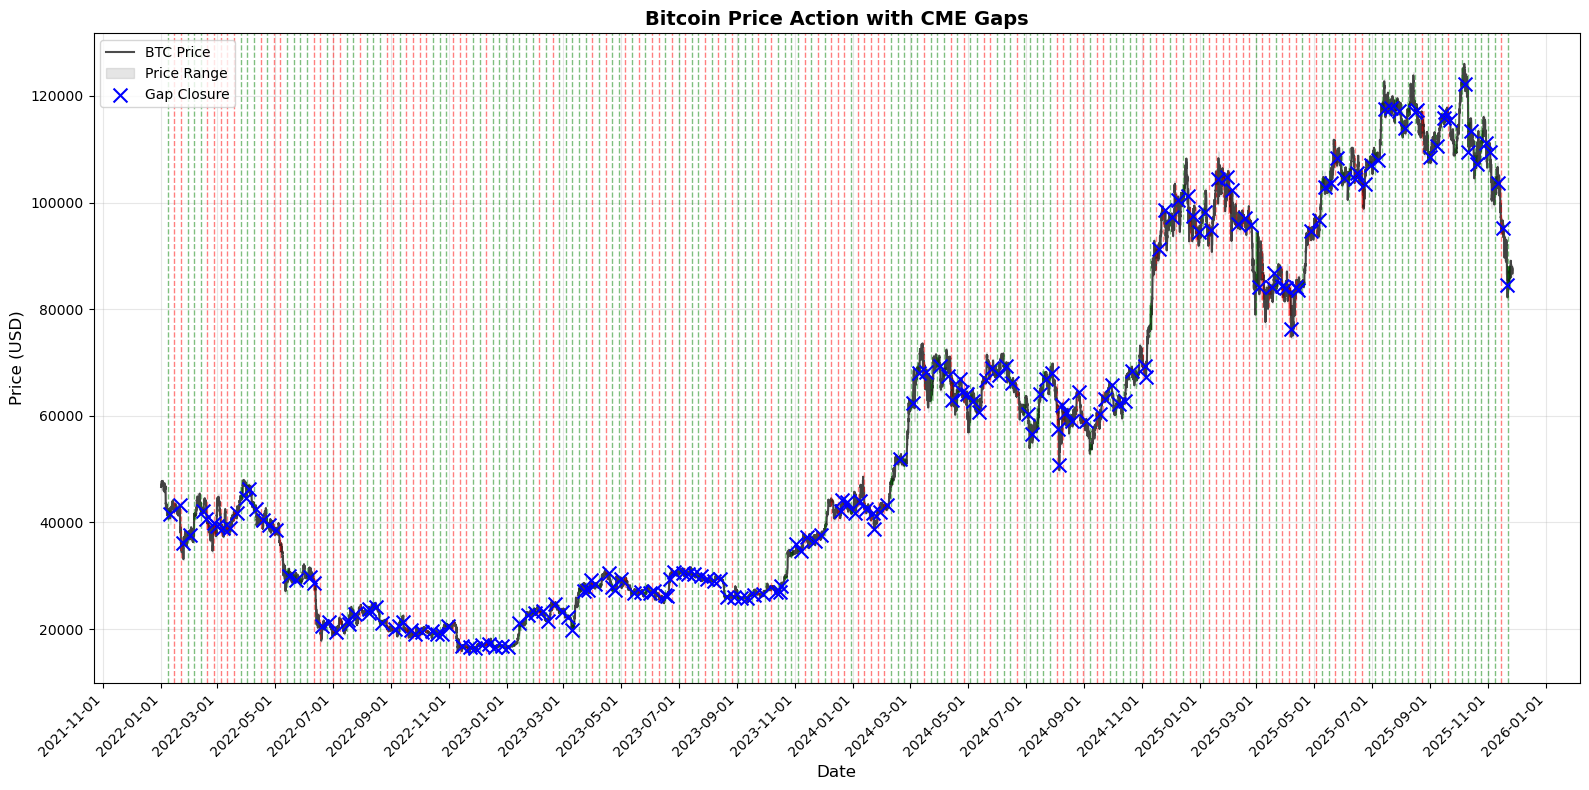

In [11]:
# Plot price action with gaps
plot_price_action_with_gaps(df, gaps_df)


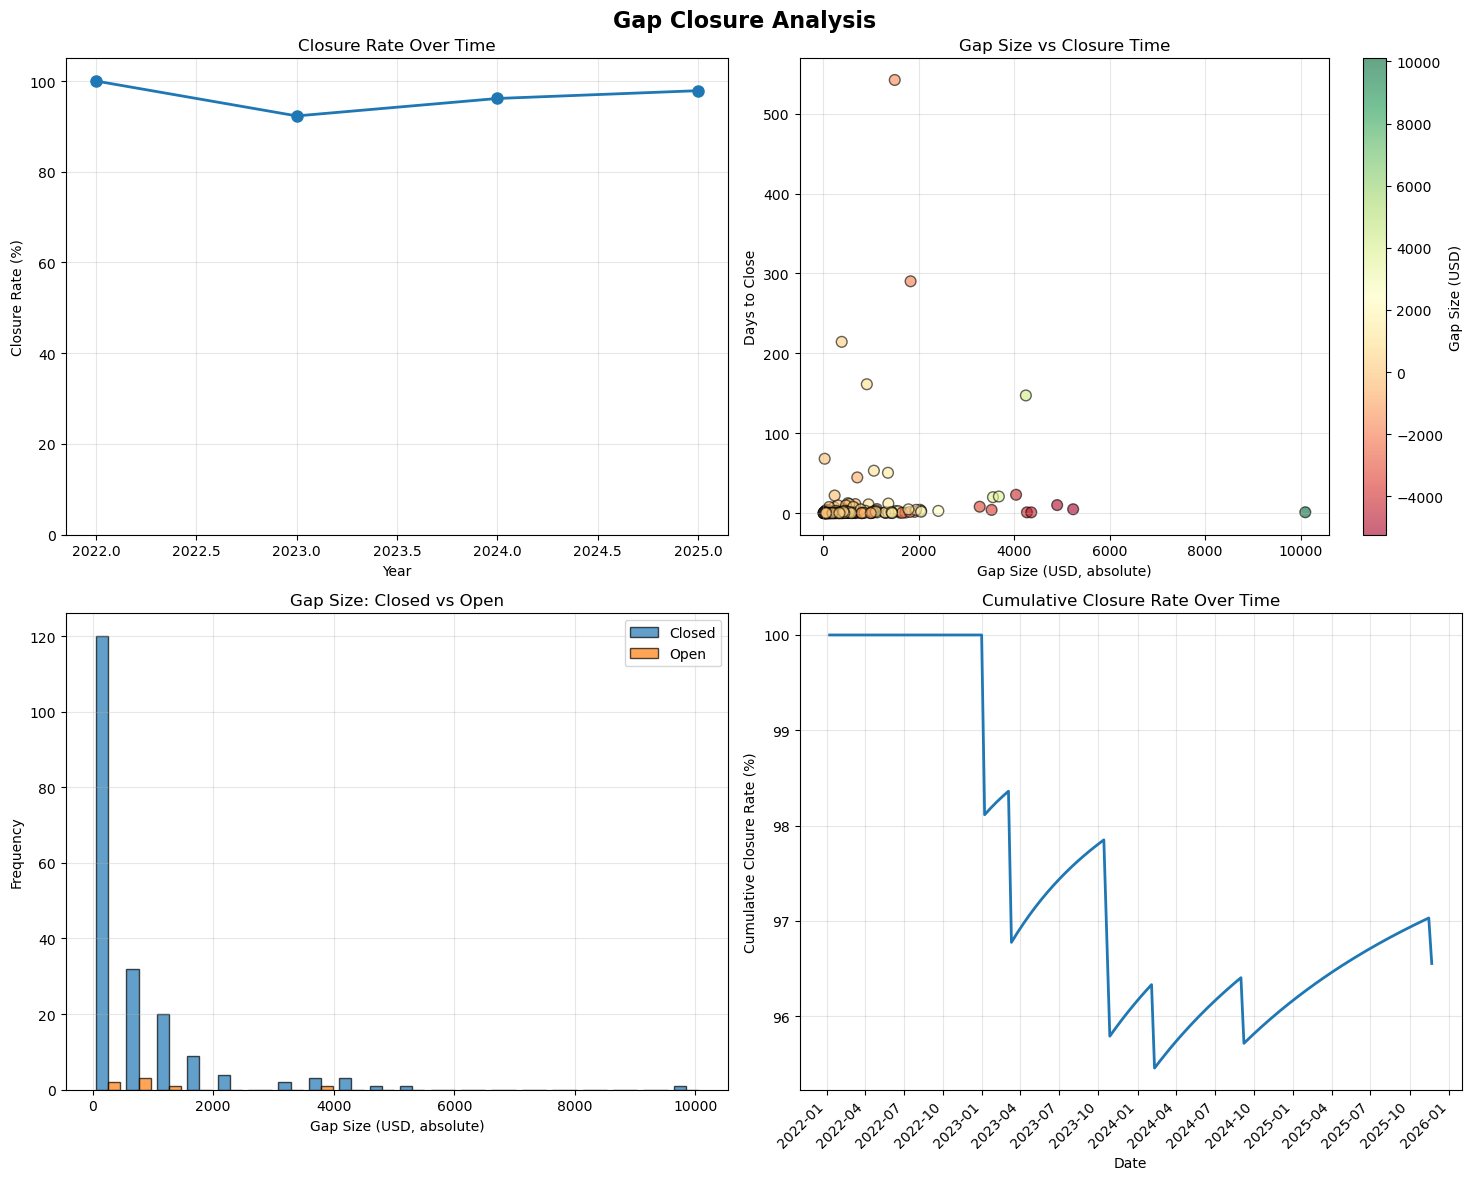

In [12]:
# Plot closure analysis
plot_closure_analysis(gaps_df)


## Custom Analysis

You can perform additional custom analysis here.


In [13]:
# Example: Analyze gaps by year
gaps_df['year'] = pd.to_datetime(gaps_df['gap_start']).dt.year
yearly_summary = gaps_df.groupby('year').agg({
    'gap_size': ['count', 'mean', 'std'],
    'is_closed': 'sum'
})
print(yearly_summary)


     gap_size                          is_closed
        count        mean          std       sum
year                                            
2022       52  -39.743654   629.270881        52
2023       52  130.097692   450.606779        48
2024       52  177.282500  1388.965176        50
2025       47  103.332979  2393.453209        46
